In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from functools import partial

c:\Users\34644\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\34644\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\34644\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from paths import CAR_IMAGES_DIR  # YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES

In [3]:
INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name in os.listdir(CAR_IMAGES_DIR)]

In [9]:
INDIVIDUAL_IMG_PATHS[0]

WindowsPath('C:/Users/34644/Desktop/Firts Semester/Vision and learning/archive (4)/images/Cars0.png')

In [4]:
def binary_methods(image_path, method = 'simple'):
    image = cv.imread(str(image_path))

    # Convert the image from BGR to RGB
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

    if method == 'original':
        return image_rgb
    
    if method == 'simple':
        binary__image = cv.threshold(image_gray, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(image_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    elif method == 'Gaus_otsu':
        blur = cv.GaussianBlur(image_gray, (5, 5), 0)
        _, binary__image = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

In [12]:
def plot_binary_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

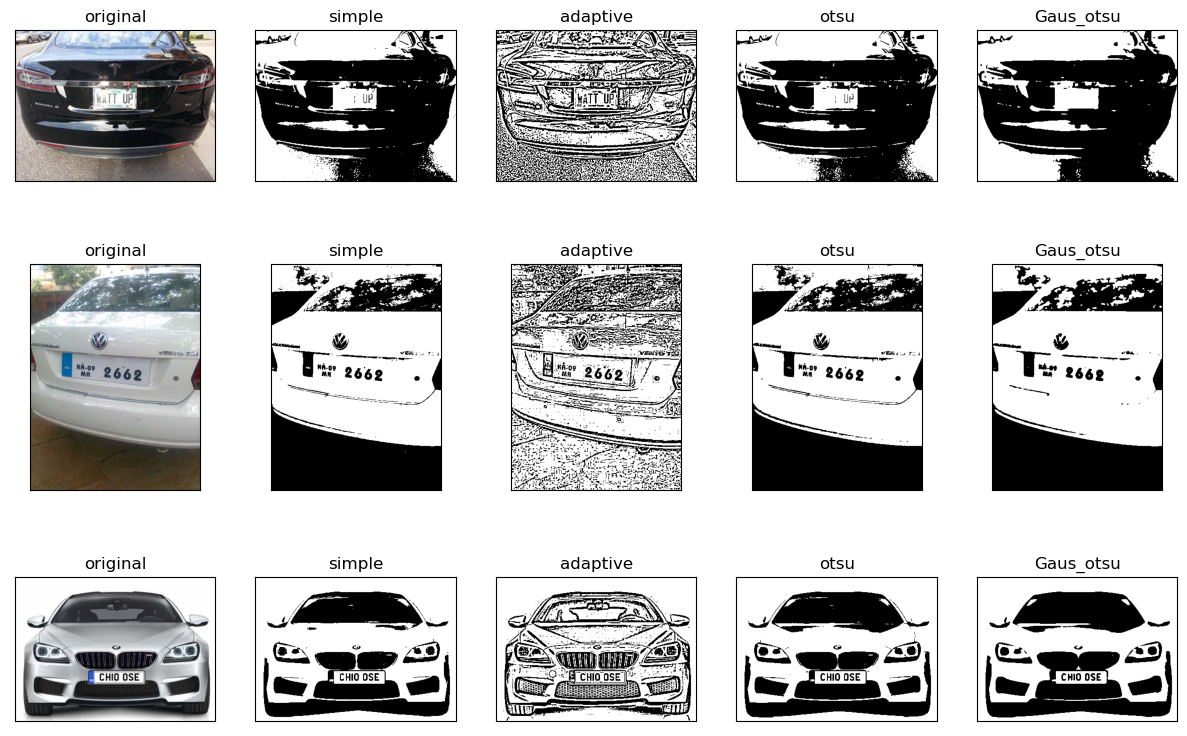

In [15]:
plot_binary_methods()

In [52]:
def mhorp_operations(binary_image, method = 'dilation', image_path = None):
    kernel = np.ones((2,5),np.uint8)
    
    if method == 'original':
        image = cv.imread(str(image_path))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image_rgb
    
    if method == 'dilation':
        result = cv.dilate(binary_image, kernel, iterations = 1)

    elif method == 'erosion':
        result = cv.erode(binary_image, kernel, iterations = 1)

    elif method == 'opening':
        result = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)

    elif method == 'closing':
        result = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)

    return result

In [54]:
def plot_mhorp_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'dilation', 'erosion', 'opening', 'closing']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
        
        binary_image = binary_methods(image_path, method = 'simple')
        output = mhorp_operations(binary_image, method = methods[pos], image_path=image_path)
        plt.subplot(3, len(methods), i+1)
        plt.imshow(output, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

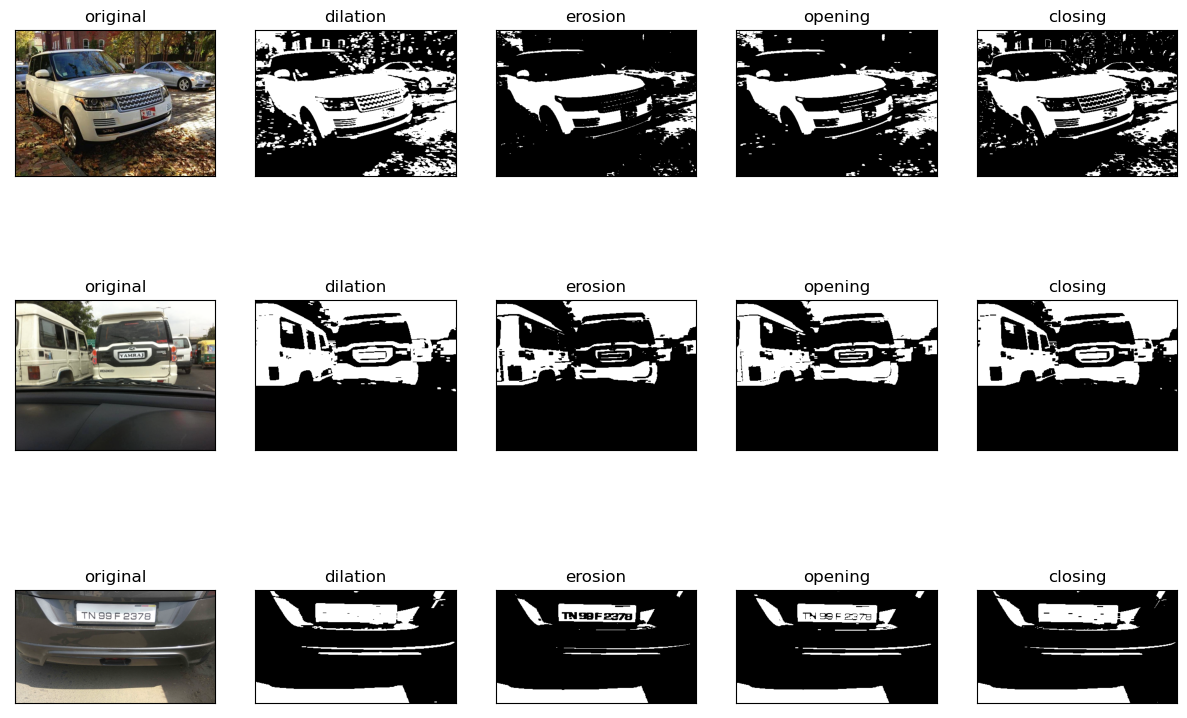

In [55]:
plot_mhorp_methods()